# Исследование тарифов телеком компании

**Содержание** 
<a id=0> </a>

[Введение](#1)  
[Предобработка данных](#2)  
[Исследование пользователей](#3)   
[Анализ и визуализация](#4)  
[Выдвижение гипотез](#5)  
[Вывод](#6)

## Введение 
<a id=1> </a>

В нашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. И наша адача: проанализировать данные и предложить решение.  
Мы будем проводить анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф приносит больше денег компании.

In [1]:
# имортируем необходимые библиотеки
import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats as st 

import math
from datetime import datetime 

## Предварительная обработка данных
<a id=2> </a>

In [2]:
# прочтем данные
try:
    calls = pd.read_csv('/datasets/calls.csv') 
    internet = pd.read_csv('/datasets/internet.csv', index_col=[0]) 
    messages = pd.read_csv('/datasets/messages.csv') 
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv') 
except FileNotFoundError:
    calls = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 4 telecom tariffs/calls.csv') 
    internet = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 4 telecom tariffs/internet.csv', index_col=[0]) 
    messages = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 4 telecom tariffs/messages.csv') 
    tariffs = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 4 telecom tariffs/tariffs.csv')
    users = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 4 telecom tariffs/users.csv')
    
display(calls)
calls.info() # изучим информацию о данных

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Видим, что в данных нет пропусков. В колонке 'duration' есть значение 0.00 - это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
Данные о дате и времени переведем в формат datetime для удобства работы.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') # изменим формат даты-времени
calls['call_date'].dtype # проверим, что получилось

dtype('<M8[ns]')

Длительность разговора записана с точностью до секунд, но, согласно условиям тарифов компании, секунды округляются до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округлим минуты разговора до целого в бОльшую сторону.

In [4]:
calls['duration'] = calls['duration'].apply(math.ceil) # округлим до минут в бОльшую сторону, используя list comprehension
 
calls # выведем результат на экран

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [5]:
display(internet)
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Дату так же как и в прошлой таблице поменяем на удобный формат. 

In [6]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
# изменим формат даты-времени

internet 

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Все хорошо.

In [7]:
display(messages)
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Та же история с датой.

In [8]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') # изменим формат даты-времени
messages['message_date'].dtype # проверим, что получилось

dtype('<M8[ns]')

In [9]:
display(tariffs) # данные до обработки
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs.rename(columns={'tariff_name': 'tariff', 'mb_per_month_included': 'gb_per_month_included'}, inplace = True) # переименуем колонку с названием тарифа

tariffs # данные после обработки

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


In [10]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [11]:
users.isna().sum() # проверим наличие пропусков

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

 В этой таблице пропуски наблюдаются только в столбце с прекращением пользования тарифом, а из условия мы знаем, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных, поэтому мы можем просто оставить эти пропуски.

[Содержание](#0)

## Исследование пользователей
<a id=3> </a>

Для каждого пользователя посчитаем:

1. количество сделанных звонков и израсходованных минут разговора по месяцам;
2. количество отправленных сообщений по месяцам;
3. объем израсходованного интернет-трафика по месяцам;
4. помесячную выручку с каждого пользователя.

### Исследуем звонки

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам. Для этого создадим 2 сводные таблицы.

In [12]:
calls['month'] = calls['call_date'].dt.month # добавим колонку с месяцем
calls_stat = (calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc=['count', 'sum'])) 
# посчитаем количесвто звонков для каждого пользователя по месяцам и продолжительность разговоров в минутах.
calls_stat = calls_stat.rename(columns={'count': 'calls', 'sum': 'duration'}) # поменяем названия столбцов
calls_stat = calls_stat.droplevel(1, axis=1) # избавимся от лишних индексов
display(calls_stat)

calls  duration
user_id month                 
1000    5         22       159
        6         43       172
        7         47       340
        8         52       408
        9         58       466
...              ...       ...
1498    10        41       247
1499    9          9        70
        10        68       449
        11        74       612
        12        69       492

[3174 rows x 2 columns]

### Исследуем сообщения

Посчитаем количество отправленных сообщений по месяцам.

In [13]:
messages['month'] = messages['message_date'].dt.month
mess_stat = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
mess_stat = mess_stat.rename(columns={'id':'messages'})
mess_stat

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

### Исследуем интернет-трафик

Посчитаем объем израсходованного интернет-трафика по месяцам.
По условиям оператора, для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. 

Для начала сделаем группировку трафика по месяцам для каждого пользователя и округлим объем их месячного трафика до гигабайт.

In [14]:
internet['month'] = internet['session_date'].dt.month # добавим колонку с месяцем
internet_stat = internet.pivot_table(index = ['user_id', 'month'], values='mb_used', aggfunc='sum')
calls['duration'] = [math.ceil(i) for i in calls['duration']] # округлим до минут в бОльшую сторону, используя list comprehension
internet_stat['mb_used']/=1024 # переведем в гигабайты
internet_stat['mb_used'] = [math.ceil(i) for i in internet_stat['mb_used']] #округлим до целого в бОльшую сторону
internet_stat = internet_stat.rename(columns={ 'mb_used': 'gb_used'}) # поменяем название колонки на Gb
internet_stat # выведем результат на экран

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

### Исследуем выручку

Соберем все полученные данные в 1 таблицу. Добавим в нее так же названия и описание тарифов.

In [15]:
# соединим таблицы методом merge(), используя для слияния колонки с уникальным 'user_id' и месяцем
data = internet_stat.merge(calls_stat, on=['user_id', 'month'], how='outer')
data = data.merge(mess_stat, on=['user_id', 'month'], how='outer')

data = data.reset_index() # сбросим индексы, чтобы 'user_id' и 'month' стали полноценными колонками

data = data.merge(users[['tariff', 'user_id', 'city']], on='user_id',  how='outer') # присоединим колонку с названием тарифа

data

,user_id,month,gb_used,calls,duration,messages,tariff,city
0,1000,5.0,3.0,22.0,159.0,22.0,ultra,Краснодар
1,1000,6.0,23.0,43.0,172.0,60.0,ultra,Краснодар
2,1000,7.0,14.0,47.0,340.0,75.0,ultra,Краснодар
3,1000,8.0,14.0,52.0,408.0,81.0,ultra,Краснодар
4,1000,9.0,15.0,58.0,466.0,57.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1273,10.0,NaN,40.0,315.0,35.0,ultra,Курган
3212,1273,11.0,NaN,45.0,272.0,29.0,ultra,Курган
3213,1273,12.0,NaN,41.0,260.0,39.0,ultra,Курган
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский


In [16]:
display(data.isna().sum()) # проверим на наличие пропусков


user_id       0
month         2
gb_used      13
calls        42
duration     42
messages    499
tariff        0
city          0
dtype: int64

Скорее всего, эти пропуски не являются ошибкой, а появились из-за того, что кто-то не писал смс и не совершал звонки, что не удивительно - сейчас это можно удобно делать через мессенджеры. Поэтому просто заменим эти пропуски нулями. После чего приведем к нужному цельночисленному формату.

In [17]:
data = data.fillna(0)
data[['month', 'calls', 'duration', 'messages', 'gb_used']]= np.int64(np.ceil(data[['month', 'calls', 'duration', 'messages', 'gb_used']]))
# переведем в цельночисленный формат все данные 
data

,user_id,month,gb_used,calls,duration,messages,tariff,city
0,1000,5,3,22,159,22,ultra,Краснодар
1,1000,6,23,43,172,60,ultra,Краснодар
2,1000,7,14,47,340,75,ultra,Краснодар
3,1000,8,14,52,408,81,ultra,Краснодар
4,1000,9,15,58,466,57,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган
3212,1273,11,0,45,272,29,ultra,Курган
3213,1273,12,0,41,260,39,ultra,Курган
3214,1128,0,0,0,0,0,ultra,Волжский


In [18]:
data.duplicated().sum() # проверим на наличие дубликатов

0

In [19]:
display(data['duration'].max()) # максимальное количество израсходованных минут
display(data['messages'].max()) # максимальное количество израсходованнах смс сообщениц
data['gb_used'].max() # максимальное количество гигабайт трафика 

1673

224

49

Создадим столбец с остатком неоплаченных минут. Т.к. в тарифный план 'Ultra' входит 3000 минут и никто их пользователей их не израсходовал, мы не будем включать эту ветвь в функцию.

In [20]:
def rest_minutes(row): # напишем функцию для подсчета неоплаченных минут сверх тарифа
    duration = row['duration']
    tariff = row['tariff']
    
    minutes_limit = tariffs[tariffs['tariff']== tariff]['minutes_included'].values[0]
    if tariff =='smart':
        if duration > minutes_limit:
            return (duration-minutes_limit)
        return 0
    else:
        return 0
data['rest_minutes'] = data.apply(rest_minutes, axis=1) # применим функцию к датасету
data 

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes
0,1000,5,3,22,159,22,ultra,Краснодар,0
1,1000,6,23,43,172,60,ultra,Краснодар,0
2,1000,7,14,47,340,75,ultra,Краснодар,0
3,1000,8,14,52,408,81,ultra,Краснодар,0
4,1000,9,15,58,466,57,ultra,Краснодар,0
...,...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган,0
3212,1273,11,0,45,272,29,ultra,Курган,0
3213,1273,12,0,41,260,39,ultra,Курган,0
3214,1128,0,0,0,0,0,ultra,Волжский,0


Проделаем то же самое с сообщениями. И опять же, количество sms, включенныx в тариф 'Ultra' никому не удалось израсходовать.

In [21]:
def rest_sms(row): # напишем функцию для подсчета неоплаченных sms сверх тарифа
    messages = row['messages']
    tariff = row['tariff']
    
    messages_limit = tariffs[tariffs['tariff']== tariff]['messages_included'].values[0]
    if tariff =='smart':
        if messages > messages_limit:
            return (messages-messages_limit)
        return 0
    return 0
        
data['rest_sms'] = data.apply(rest_sms, axis=1) # применим функцию к датасету
data 

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms
0,1000,5,3,22,159,22,ultra,Краснодар,0,0
1,1000,6,23,43,172,60,ultra,Краснодар,0,0
2,1000,7,14,47,340,75,ultra,Краснодар,0,0
3,1000,8,14,52,408,81,ultra,Краснодар,0,0
4,1000,9,15,58,466,57,ultra,Краснодар,0,0
...,...,...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган,0,0
3212,1273,11,0,45,272,29,ultra,Курган,0,0
3213,1273,12,0,41,260,39,ultra,Курган,0,0
3214,1128,0,0,0,0,0,ultra,Волжский,0,0


Повторим для интернет-трафика. Тут уже и некоторым владельцам тарифа 'Ultra' не повезло и придется заплатить за перерасход трафика.

In [22]:
def rest_gb(row): # напишем функцию для подсчета неоплаченного трафика сверх тарифа
    mb_used = row['gb_used']
    tariff = row['tariff']
    
    mb_limit = tariffs[tariffs['tariff']== tariff]['gb_per_month_included'].values[0]
    
    if mb_used > mb_limit:
        return (mb_used-mb_limit)
    return 0
    
data['rest_gb'] = data.apply(rest_gb, axis=1) # применим функцию к датасету
data 

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms,rest_gb
0,1000,5,3,22,159,22,ultra,Краснодар,0,0,0.0
1,1000,6,23,43,172,60,ultra,Краснодар,0,0,0.0
2,1000,7,14,47,340,75,ultra,Краснодар,0,0,0.0
3,1000,8,14,52,408,81,ultra,Краснодар,0,0,0.0
4,1000,9,15,58,466,57,ultra,Краснодар,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган,0,0,0.0
3212,1273,11,0,45,272,29,ultra,Курган,0,0,0.0
3213,1273,12,0,41,260,39,ultra,Курган,0,0,0.0
3214,1128,0,0,0,0,0,ultra,Волжский,0,0,0.0


Теперь у нас есть таблица со всеми данными, необходимыми для анализа.

Посчитаем общую абонентскую плату каждого пользователя по месяцам.

In [23]:
def money(row):
    tariff = row['tariff']
    rest_minutes = row['rest_minutes']
    rest_sms = row['rest_sms']
    rest_gb = row['rest_gb']
    if tariff == 'smart':
        return rest_minutes*3 + rest_sms*3 + rest_gb*200 + 550
    return rest_minutes*1 + rest_sms*1 + rest_gb*150 + 1950
data['income'] = data.apply(money, axis=1)
data

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms,rest_gb,income
0,1000,5,3,22,159,22,ultra,Краснодар,0,0,0.0,1950.0
1,1000,6,23,43,172,60,ultra,Краснодар,0,0,0.0,1950.0
2,1000,7,14,47,340,75,ultra,Краснодар,0,0,0.0,1950.0
3,1000,8,14,52,408,81,ultra,Краснодар,0,0,0.0,1950.0
4,1000,9,15,58,466,57,ultra,Краснодар,0,0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган,0,0,0.0,1950.0
3212,1273,11,0,45,272,29,ultra,Курган,0,0,0.0,1950.0
3213,1273,12,0,41,260,39,ultra,Курган,0,0,0.0,1950.0
3214,1128,0,0,0,0,0,ultra,Волжский,0,0,0.0,1950.0


Добравим в таблицу дополниьельный столбец в котором будет либо Москва либо другой регион. Это понадобится нам в дальнейшем исследовании.

In [24]:
def moscow(row): # напишем функцию
    city = row['city']
    if city == 'Москва':
        return 'Москва'
    return 'Другой регион'
data['moscow_or_not'] = data.apply(moscow, axis=1)
data

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms,rest_gb,income,moscow_or_not
0,1000,5,3,22,159,22,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
1,1000,6,23,43,172,60,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
2,1000,7,14,47,340,75,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
3,1000,8,14,52,408,81,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
4,1000,9,15,58,466,57,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1273,10,0,40,315,35,ultra,Курган,0,0,0.0,1950.0,Другой регион
3212,1273,11,0,45,272,29,ultra,Курган,0,0,0.0,1950.0,Другой регион
3213,1273,12,0,41,260,39,ultra,Курган,0,0,0.0,1950.0,Другой регион
3214,1128,0,0,0,0,0,ultra,Волжский,0,0,0.0,1950.0,Другой регион


[Содержание](#0)

## Анализ и визуализация полученных данных
<a id=4> </a>

Посмотрим на общее описание данных.

In [25]:
data['income'].describe() # выведем информацию о столбце с прибылью от каждого пользователя

count    3216.000000
mean     1528.902674
std       798.224060
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: income, dtype: float64

В среднем пользователи тратят на связь 1456 р в месяц, минимум - наш тириф 'Smart' или 550 р, а максимум - 6617 р. Для кого-то связь очень важна. Медианное значение близко к среднему - 1550, величина стандартного отклонения - 777 р, что говорит нам о том, что поведение одних пользователей очень сильно отличается от поведения других. Так же найдем дисперсию.

In [26]:
display(np.var(data['income'], ddof=1)) # найдем дисперсию
np.sqrt(np.var(data['income'])) # корень из дисперсии = стандартному отклонению

637161.6505558328

798.0999487232492

Для отображения наших данных нарисуем диаграмму ящика с усами, которая покажет нам все те же данные. Но по ней видно, что например значения больше 4000 - можно признать выбросами.

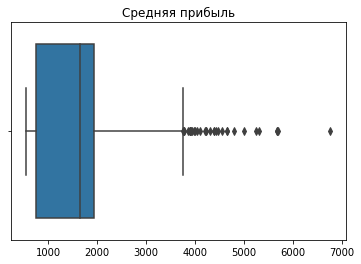

In [45]:
sns.boxplot(x=data['income'])
plt.title('Средняя прибыль')
plt.xlabel('');

А еще можно нарисовать тот же график с распределением прибыли по месяцам, и судя по нему - в декабре люди тратят больше всего денег на связь, а в январе - меньше всего. По всей видимости это связано с предновогодней лихорадкой и сезоном отпусков.

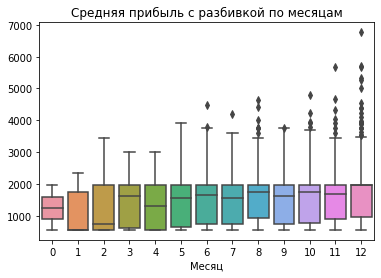

In [46]:
sns.boxplot(x="month", y="income", data=data)
plt.title('Средняя прибыль с разбивкой по месяцам')
plt.xlabel('Месяц')
plt.ylabel('');

In [29]:
data_pivot = data.pivot_table(index=['user_id', 'month', 'tariff', 'city'], values = ['duration', 'messages', 'gb_used', 'income'], aggfunc='mean').reset_index()
data_pivot

,user_id,month,tariff,city,duration,gb_used,income,messages
0,1000,5,ultra,Краснодар,159,3,1950.0,22
1,1000,6,ultra,Краснодар,172,23,1950.0,60
2,1000,7,ultra,Краснодар,340,14,1950.0,75
3,1000,8,ultra,Краснодар,408,14,1950.0,81
4,1000,9,ultra,Краснодар,466,15,1950.0,57
...,...,...,...,...,...,...,...,...
3211,1498,10,smart,Владикавказ,247,21,1750.0,42
3212,1499,9,smart,Пермь,70,2,550.0,11
3213,1499,10,smart,Пермь,449,18,1150.0,48
3214,1499,11,smart,Пермь,612,18,1513.0,59


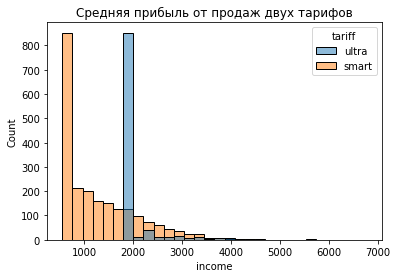

In [30]:
sns.histplot(data=data, x='income', hue= 'tariff', bins=30)
plt.title('Средняя прибыль от продаж двух тарифов')
plt.show()

Видим, что в среднем люди не выходят за пределы своего тарифа - большая часть выбросов в районе стоимости тарифа. То есть это и не выбросы вовсе - большой чести пользователей хватает их тарифов и они не тратят больше минут, смс и интернета.  
По гистограмме распределения так же видно, что владельцы тарифа Smart в целом "объемнее", то есть приносят компании много небольших прибылей, но владельцы Ultra берут абанентской платой и большим объемом интернет-трафика, за счет чего среднее все-таки на стороне Ultra.

Разделим изначальную таблицу data, в которую мы собирали все даннве на две по тарифам.

In [31]:
data_smart = data.query('tariff == "smart"') # отфильтруем по названию тарифа

data_smart

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms,rest_gb,income,moscow_or_not
8,1001,11,18,59,430,0,smart,Москва,0,0,3.0,1150.0,Москва
9,1001,12,14,63,414,0,smart,Москва,0,0,0.0,550.0,Москва
10,1002,6,11,15,117,4,smart,Стерлитамак,0,0,0.0,550.0,Другой регион
11,1002,7,18,26,214,11,smart,Стерлитамак,0,0,3.0,1150.0,Другой регион
12,1002,8,20,42,289,13,smart,Стерлитамак,0,0,5.0,1550.0,Другой регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,1499,9,2,9,70,11,smart,Пермь,0,0,0.0,550.0,Другой регион
3203,1499,10,18,68,449,48,smart,Пермь,0,0,3.0,1150.0,Другой регион
3204,1499,11,18,74,612,59,smart,Пермь,112,9,3.0,1513.0,Другой регион
3205,1499,12,13,69,492,66,smart,Пермь,0,16,0.0,598.0,Другой регион


In [32]:
data_ultra = data.query('tariff == "ultra"') # отфильтруем по названию тарифа
data_ultra

,user_id,month,gb_used,calls,duration,messages,tariff,city,rest_minutes,rest_sms,rest_gb,income,moscow_or_not
0,1000,5,3,22,159,22,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
1,1000,6,23,43,172,60,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
2,1000,7,14,47,340,75,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
3,1000,8,14,52,408,81,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
4,1000,9,15,58,466,57,ultra,Краснодар,0,0,0.0,1950.0,Другой регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,1273,9,0,33,223,32,ultra,Курган,0,0,0.0,1950.0,Другой регион
3211,1273,10,0,40,315,35,ultra,Курган,0,0,0.0,1950.0,Другой регион
3212,1273,11,0,45,272,29,ultra,Курган,0,0,0.0,1950.0,Другой регион
3213,1273,12,0,41,260,39,ultra,Курган,0,0,0.0,1950.0,Другой регион


Интересно проверить, много ли людей пользуются тарифом Smart, но при этом платят за него столько же как за тариф Ultra.

In [33]:
more_then_ultra = 0 # создадим переменную-счетчик
for i in data_smart['income']: # напишем цикл, который посчитает значения больше стоимости тарифа ultra
    if i >= 1950:
        more_then_ultra +=1
more_then_ultra

471

Данные уже отфильтрованы по месяцам и пользователем, поэтому здесь 471 месяц, когда кто-то из пользователей тарифа Smart тратил больше денег на связь, чем стоит тариф Ultra. Возможно службе по работе с клиентам стоит заняться этим вопросам и продать этим пользователям более дорогой тариф.

Построим графики сравнения 2 тарифов по потраченным минутам, смс и интернет-трафику.

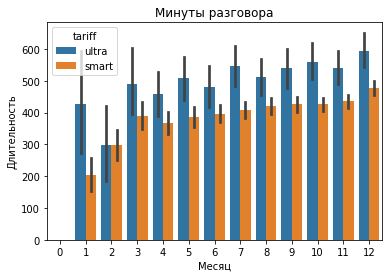

In [48]:
sns.barplot(x="month", y="duration", hue = 'tariff', data=data_pivot)
plt.title('Минуты разговора')
plt.ylabel('Длительность')
plt.xlabel('Месяц');

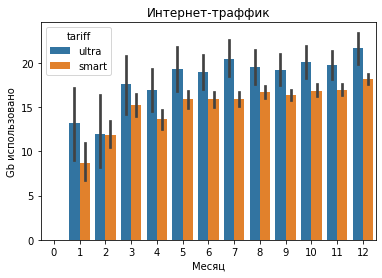

In [49]:
sns.barplot(x="month", y="gb_used", hue = 'tariff', data=data_pivot)
plt.title('Интернет-траффик')
plt.ylabel('Gb использовано')
plt.xlabel('Месяц');

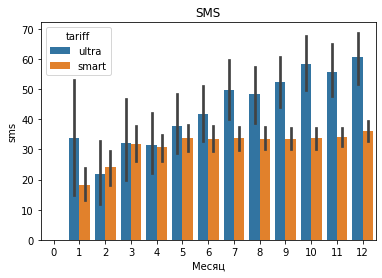

In [50]:
sns.barplot(x="month", y="messages", hue = 'tariff', data=data_pivot)
plt.title('SMS')
plt.ylabel('sms')
plt.xlabel('Месяц');

Теперь посмотрим на разницу в прибыли.

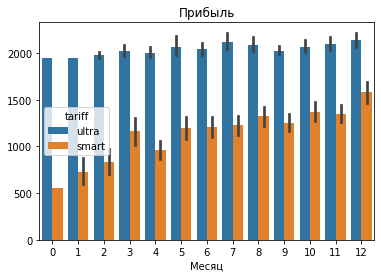

In [51]:
sns.barplot(x='month', y='income', hue = 'tariff', data=data_pivot)
plt.title('Прибыль')
plt.ylabel('')
plt.xlabel('Месяц');

Исходя из предоставленной нам выборки можно сделать вывод, что пользователи тарифа Ultra используют больше услуг всех аспектов связи: и смс, и звонков, и интернета. И прибыли компании пользователи этого тарифа приносят значительно больше.

In [38]:
# для тарифа Smart
calls_var_smart = np.var(data_smart['calls'], ddof=1)
calls_std_smart = np.sqrt(calls_var_smart)
gb_var_smart = np.var(data_smart['gb_used'], ddof=1)
gb_std_smart = np.sqrt(gb_var_smart)
messages_var_smart = np.var(data_smart['messages'], ddof=1)
messages_std_smart = np.sqrt(messages_var_smart)

#для тарифа Ultra
calls_var_ultra = np.var(data_ultra['calls'], ddof=1)
calls_std_ultra = np.sqrt(calls_var_ultra)
gb_var_ultra = np.var(data_ultra['gb_used'], ddof=1)
gb_std_ultra = np.sqrt(gb_var_ultra)
messages_var_ultra = np.var(data_ultra['messages'], ddof=1)
messages_std_ultra = np.sqrt(messages_var_ultra)
print('Для тарифа Smart')
print()
print('Среднее количество звонков =', data_smart['calls'].mean())
print("Дисперсия =", calls_var_smart)
print("Стандартное отклонение =" , calls_std_smart)
print('Среднее количество  использованных Гб =', data_smart['gb_used'].mean())
print("Дисперсия =", gb_var_smart)
print("Стандартное отклонение =" , gb_std_smart)
print('Среднее количество  sms =', data_smart['messages'].mean())
print("Дисперсия =", messages_var_smart)
print("Стандартное отклонение =" , messages_std_smart)
print()
print('Для тарифа Ultra')
print()
print('Среднее количество звонков =', data_ultra['calls'].mean())
print("Дисперсия =", calls_var_ultra)
print("Стандартное отклонение =" , calls_std_ultra)
print('Среднее количество  использованных Гб =', data_ultra['gb_used'].mean())
print("Дисперсия =", gb_var_ultra)
print("Стандартное отклонение =" , gb_std_ultra)
print('Среднее количество  sms =', data_ultra['messages'].mean())
print("Дисперсия =", messages_var_ultra)
print("Стандартное отклонение =" , messages_std_ultra)
print()


Для тарифа Smart

Среднее количество звонков = 58.437219730941706
Дисперсия = 674.1070932087625
Стандартное отклонение = 25.963572427706527
Среднее количество  использованных Гб = 16.32152466367713
Дисперсия = 33.133453035506285
Стандартное отклонение = 5.7561665225657155
Среднее количество  sms = 33.36905829596412
Дисперсия = 796.9552557301128
Стандартное отклонение = 28.23039595418585

Для тарифа Ultra

Среднее количество звонков = 73.3184584178499
Дисперсия = 1932.1949279764417
Стандартное отклонение = 43.956739278254496
Среднее количество  использованных Гб = 19.474645030425965
Дисперсия = 97.37854429011234
Стандартное отклонение = 9.868056763624352
Среднее количество  sms = 49.31338742393509
Дисперсия = 2285.4174246558414
Стандартное отклонение = 47.80603962530092



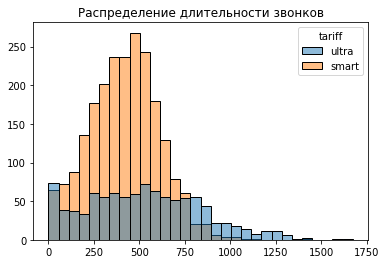

In [53]:
sns.histplot(data=data, x='duration', hue= 'tariff', bins=30)
plt.title('Распределение длительности звонков')
plt.xlabel('')
plt.ylabel('');

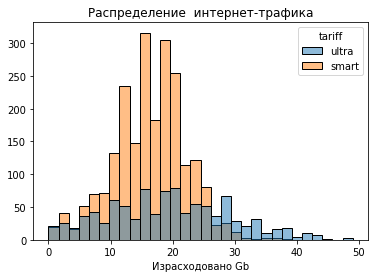

In [54]:
sns.histplot(data=data, x='gb_used', hue= 'tariff', bins=30)
plt.title('Распределение  интернет-трафика')
plt.xlabel('Израсходовано Gb')
plt.ylabel('');

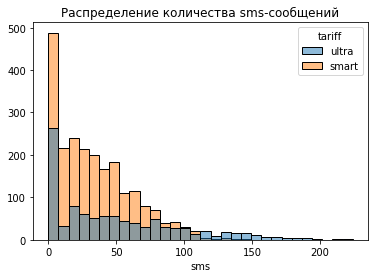

In [55]:
sns.histplot(data=data, x='messages', hue= 'tariff', bins=30)
plt.title('Распределение количества sms-сообщений')
plt.xlabel('sms')
plt.ylabel('');

Из гистрограмм распределения видно то же что мы уже увидели на гистограмме с прибылью - много звонков, смс и Гб у пользователей Smart, но "хвосты" от Ultra вытягивают среднюю прибыль. 

[Содержание](#0)

## Выдвижение гипотез
<a id=5> </a>

### Гипотеза 1

На данном этапе наши данные готовы к тому, чтобы мы могли выдвинуть ряд гипотез, которые интересуют нашего заказчика.


Первой проверим гипотезу о том, что средняя выручка от пользователей тарифов «Ультра» и «Смарт» различаются. Примем за нулевую гипотезу, что выручки от тарифов равны, тогда нашей альтернативной гипотезой будет - выручка от тарифа 'Ultra' больше чем от 'Smart'. Это односторонняя гипотеза. 

Есть подозрение, что пользователи двух тарифов сильно отличаются друг от друга и соответвтвенно дисперсия в первом и во втором случае могут так же сильно отличаться, поэтому мы укажем это как дополнительный параметр при проведении  t-теста.

In [42]:
alpha = .05 # зададим уровень статистической значимости в 5%
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind( # проведем t-test, сравним среднее двух тарифов, добавим допольнительный параметр equal_var = False 
    data_ultra['income'], 
    data_smart['income'], equal_var = False) 
print('p-value =', results.pvalue)

if (results.pvalue/2) < alpha: # гипотеза односторонняя - результат p/value разделим на 2
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
# сравним среднее двух выборок
if data_ultra['income'].mean() < data_smart['income'].mean():
    print ('Прибыль Ultra меньше, чем Smart')
else:
    print ('Прибыль Ultra больше, чем Smart')

p-value = 1.927011394420941e-250
Отвергаем нулевую гипотезу
Прибыль Ultra больше, чем Smart


Мы получили значение p-value сильно ниже уровня статистической значимости, что означает что вероятность того, что средний уровень дохода от пользователей двух тарифов одинаковый - ничтожно мала, и мы можем смело отвергуть нулевую гипотезу.

### Гипотеза 2

Сформулируем вторую гипотезу: средняя выручка от пользователей из Москвы отличается от выручки пользователей из других регионов. Здесь нулевой гипотезой будет: средняя выручка от пользователей из Москвы равна средней выручке от всех остальных пользователей. Альтернативная гипотеза: средняя выручка от москвичей отличается от остальных. Это двустороняя гипотеза.

In [43]:
data_moscow = data.query('moscow_or_not == "Москва"') # создадим 2 датасета для того, чтобы загразить их 
data_regions = data.query('moscow_or_not == "Другой регион"') # в функцию ttest_ind

In [44]:
alpha = .05 # зададим уровень статистической значимости в 5%
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind( # проведем t-test, сравним среднее двух тарифов, добавим допольнительный параметр equal_var = False 
    data_moscow['income'], 
    data_regions['income'], equal_var = False) 
print('p-value =', results.pvalue)

if results.pvalue < alpha: # сравним p-value с уровнем статистической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value = 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


А вот тут похоже данные выборки очень близки. С 40% вероятностью средняя выручка по Москве будет такой же как и в регионах.

[Содержание](#0)

## Вывод
<a id=6> </a>

Мы проанализировали данные 500 клиентов "Мегалайн", предоставленные нам компанией, очистили предоставленные данные от пропусков и ошибок, посчитали общую прибыль от каждого клиента по месяцам, а так же среднюю прибыль от каждого тарифа.
Выборка кажется нам достаточно репрезентативной и охватывает разные регионы страны.

Во-первых, можно сказать, что в тариф Ultra входит так много смс и звонков, что никому из пользователей не удалось привысить этот бесплатный лимит. Возможно этот лимит можно чуть уменьшить. 
Во-вторых, людям в тарифе Smart часто наоборот не хватало включенных минут и трафика - возможно можно было бы чуть расширить тарифный план за счет увеличения его стоимости. 

В то же время мы зафиксировали более 400 случаев, когда клиенты, пользователи тарифа Ultra переплачивали за свой тариф, хотя могли бы переключиться на более выгодный. В частности клиент из данной выборки, потративший больше всех денег - пользователь тарифа Ultra. 

В ходе визуализации данных, мы обнаружили интереснцю особенность: небольшое количество клиентов тарифа Ultra, не жалеющих денег на связь, - делают среднюю выручку от этого тарифа больше. С одной стороны, это хорошо для компании, а с другой стороны - не очень, потому что потеря любого такого клиента будет означать ощутимое падение прибыли для компании.

Мы провели 2 статистических исследования на основе предоставленной нам выборки и исходя из полученных нами данных, можно сказать что тариф Ultra приносит компании значительно больше денег, но он явно не всем по-карману.

Так же мы выдвинули гипотезу, что люди в регионах тратят меньше денег на связь и она не подтвердилась - с 40% вероятностью данные по Москве и регионах не сильно отличаются.

В целом результаты исследования достаточно предсказуемые: более дорогой тариф приносит компании больше денег. 
Возможно стоит продолжить исследование, и посмотреть как много людей вообще не пользуется звонками и смс, но интернет для них более актуален? Или насколько люди в регионах меньше пользуются интернетом чем в Москве и так ли это? 